In [46]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from datetime import datetime
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
import tensorboard
# from tensorflow.keras import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, f1_score

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec

In [3]:
#creating extra data from current files  
from datetime import datetime
from tqdm import tqdm

import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from tensorflow import keras
import bert
from bert.tokenization.bert_tokenization import FullTokenizer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert import BertModelLayer

from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 
from tensorflow.keras import backend as K

# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
import tensorboard


from tensorflow.keras.layers import Layer,Dropout, LSTM, GRU, Bidirectional, TimeDistributed, Dense

In [4]:
############################### path check (add path to data)
root_path = ''
list_of_files = []
for root, dir, files in os.walk('../data'):
  root_path = root
  list_of_files = files
  break 

In [5]:
print(root_path)
print(files)

./Annotated - CSV
['1288072330011.csv', '1288673034598.csv', '1289452697301.csv', '1289903641088.csv', '1290062946166.csv', '1290154724736_NEG.csv', '1291175003856_NEG.csv', '1312279794560.csv', '1312280268805.csv', '1314613428609.csv', '1315463402543.csv', '1324544561749.csv', '1358769139907.csv', '1372652426612.csv', '1372830044081.csv', '1380795608703.csv', '1382959468059.csv', '1404099510806.csv', '1404444629445.csv', '1404800940434.csv', '1407404311694.csv', '1407404374671.csv', '1407404413828.csv', '1409133457223.csv', '1427283185104.csv', '1494587603795.csv', '1509190608413.csv', '1522238936458.csv', '1564575450353.csv']


In [6]:
all_dataframes = []
for filename in list_of_files:
  file_path = root_path + '/' + filename
  file_temp = pd.read_csv(file_path)
  all_dataframes.append(file_temp)

In [7]:
all_dataframes[0].head()

,Sentence ID,Label,Sentence
0,F1288072330011_S1,material fact,1. The shares of Genus Commu Trade Limited (he...
1,F1288072330011_S2,procedural fact,SEBI conducted an investigation in respect of ...
2,F1288072330011_S3,material fact,"2. During the investigation period, the scrip ..."
3,F1288072330011_S4,material fact,The price reached the period low (intra day) o...
4,F1288072330011_S5,material fact,During the said period the total traded quanti...


In [8]:
result = pd.DataFrame()
result = result.append(all_dataframes,ignore_index=True)

In [9]:
def tokenize_txt(txt):
    stop_words = set(stopwords.words('english'))
    #only take words or numbers in
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+', gaps=False)
    tokens = tokenizer.tokenize(txt)
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    return tokens

def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in data]
    return ' '.join(lemmatized_text)

In [10]:
print(result.head())

         Sentence ID            Label  \
0  F1288072330011_S1    material fact   
1  F1288072330011_S2  procedural fact   
2  F1288072330011_S3    material fact   
3  F1288072330011_S4    material fact   
4  F1288072330011_S5    material fact   

                                            Sentence  
0  1. The shares of Genus Commu Trade Limited (he...  
1  SEBI conducted an investigation in respect of ...  
2  2. During the investigation period, the scrip ...  
3  The price reached the period low (intra day) o...  
4  During the said period the total traded quanti...  


In [11]:
# result['token'] = result['Sentence'].map(tokenize_txt)
# result['lemma'] = result['token'].map(lemmatization)
# result['tok_size'] = result['token'].apply(lambda x: len(x))

In [12]:
print(result.count())

Sentence ID    2264
Label          2264
Sentence       2264
dtype: int64


In [13]:
train_data = pd.DataFrame(columns= result.columns)
val_data = pd.DataFrame(columns=result.columns)
test_data = pd.DataFrame(columns=result.columns)
for label in result.Label.unique():
  temp_df = result[result['Label'] == label]
  train_index = int(temp_df.shape[0]*0.85)
  train_data = train_data.append(temp_df[:train_index])
  test_data = test_data.append(temp_df[train_index:])

In [14]:
train_data.drop(columns = ['Sentence ID'],axis=1,inplace=True)
test_data.drop(columns = ['Sentence ID'],axis=1, inplace=True)

In [15]:
train_data.head()

,Label,Sentence
0,material fact,1. The shares of Genus Commu Trade Limited (he...
2,material fact,"2. During the investigation period, the scrip ..."
3,material fact,The price reached the period low (intra day) o...
4,material fact,During the said period the total traded quanti...
5,material fact,"3. For the two months (July 01, 2004 to August..."


In [16]:
train_data['l'] = train_data['Sentence'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train_data.l.mean()))
print("max length of sentence: " + str(train_data.l.max()))
print("std dev length of sentence: " + str(train_data.l.std()))

mean length of sentence: 35.17153284671533
max length of sentence: 188
std dev length of sentence: 23.503743535760414


In [17]:
sequence_length = 188

In [18]:
classes = train_data.Label.unique().tolist()
classes

['material fact',
 'procedural fact',
 'allegation',
 'defendant claim',
 'issues framed',
 'statutory fact',
 'subjective observation',
 'violation',
 'penalty',
 'related fact']

In [19]:
max_features = 20000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(result['Sentence'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(result['Sentence'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(result['Label']).values

# where there isn't a test set, Kim keeps back 10% of the data for testing, I'm going to do the same since we have an ok amount to play with
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 227


In [20]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [21]:
my_callbacks = [EarlyStopping(patience=150, monitor="val_loss"),  ModelCheckpoint(filepath='model_cnn3.hdf5', save_best_only=False, save_weights_only = False, monitor='val_loss', mode='auto',save_freq = 'epoch'),keras.callbacks.TensorBoard(log_dir=logdir)]

In [22]:
embeddings_index = {}
f = open('./glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4059 unique tokens.


In [27]:
embedding_dim = 200 # Kim uses 300 here
num_filters = 100

In [28]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

4060


In [36]:
inputs_2 = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer_2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs_2)

reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_2)

conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_1_2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_2_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)

maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
maxpool_1_2 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_2)
maxpool_2_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_2)

concatenated_tensor_2 = Concatenate(axis=1)([maxpool_0_2, maxpool_1_2, maxpool_2_2])
flatten_2 = Flatten()(concatenated_tensor_2)

dropout_2 = Dropout(0.5)(flatten_2)
output_2 = Dense(units=10, activation='softmax')(dropout_2)

In [37]:
model_2 = Model(inputs=inputs_2, outputs=output_2)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 188)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 188, 200)     812000      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 188, 200, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 186, 1, 100)  60100       reshape_2[0][0]                  
____________________________________________________________________________________________

In [38]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [39]:
my_callbacks = [EarlyStopping(patience=150, monitor="val_loss"),  ModelCheckpoint(filepath='model_cnn2.hdf5', save_best_only=True, save_weights_only = False, monitor='val_loss', mode='auto',save_freq = 'epoch'),keras.callbacks.TensorBoard(log_dir=logdir)]

In [40]:
batch_size = 32
history_2 = model_2.fit(X_train, y_train, epochs=150, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=my_callbacks)

Epoch 1/150
51/51 [==============================] - 8s 40ms/step - loss: 3.6837 - accuracy: 0.3278 - val_loss: 2.2781 - val_accuracy: 0.3627
Epoch 2/150
51/51 [==============================] - 1s 16ms/step - loss: 2.2965 - accuracy: 0.3382 - val_loss: 2.2033 - val_accuracy: 0.3676
Epoch 3/150
51/51 [==============================] - 1s 16ms/step - loss: 2.2786 - accuracy: 0.3315 - val_loss: 2.2462 - val_accuracy: 0.3701
Epoch 4/150
51/51 [==============================] - 1s 16ms/step - loss: 2.3062 - accuracy: 0.3382 - val_loss: 2.2089 - val_accuracy: 0.2990
Epoch 5/150
51/51 [==============================] - 1s 16ms/step - loss: 2.3002 - accuracy: 0.3327 - val_loss: 2.2473 - val_accuracy: 0.3750
Epoch 6/150
51/51 [==============================] - 1s 16ms/step - loss: 2.2873 - accuracy: 0.3450 - val_loss: 2.2495 - val_accuracy: 0.3260
Epoch 7/150
51/51 [==============================] - 1s 15ms/step - loss: 2.2994 - accuracy: 0.3297 - val_loss: 2.2483 - val_accuracy: 0.3186
Epoch 

In [41]:
model = tf.keras.models.load_model('model_cnn2.hdf5')

In [42]:
y_pred = model.predict(X_test).argmax(axis=-1)

In [43]:
print(y_pred)

[1 1 1 3 1 5 1 7 1 5 1 1 1 1 3 3 1 7 1 5 3 1 5 5 1 1 7 3 1 5 1 5 1 1 7 3 1
 5 1 3 3 1 5 7 5 3 5 1 1 7 1 1 1 7 1 1 3 3 3 5 5 3 1 1 3 7 7 1 1 5 1 1 1 1
 5 1 5 1 8 1 1 1 1 5 1 1 1 5 1 3 1 5 3 1 1 1 3 3 5 1 5 1 1 1 5 5 3 1 3 1 1
 1 1 5 1 1 1 1 7 1 3 3 1 5 3 1 1 5 1 1 5 1 1 3 1 5 1 1 8 5 5 7 1 1 1 3 1 1
 1 1 1 1 5 1 5 1 3 5 1 7 1 1 1 5 3 1 5 5 1 1 5 3 1 3 5 1 5 1 3 1 5 1 5 1 1
 1 1 1 1 1 5 5 5 3 1 5 1 1 5 1 1 5 5 3 1 1 1 1 3 5 1 3 1 5 5 1 1 3 5 1 1 1
 1 1 1 3 1]


In [68]:
y_test_final = []
for i in y_test:
    y_test_final.extend(np.where(i==1)[0])
y_test_final = np.array(y_test_final)
print(y_test_final)

[5 1 3 2 8 3 1 5 1 1 1 1 2 1 0 8 7 5 3 9 3 8 1 1 3 8 5 1 3 1 5 5 5 3 2 7 5
 1 9 1 8 1 6 6 8 1 4 1 3 1 1 3 6 5 8 3 8 8 2 7 8 1 0 3 0 5 3 3 3 2 7 1 1 8
 1 8 3 3 0 3 1 1 1 4 0 0 1 5 1 1 1 1 4 1 5 5 1 1 3 8 0 1 9 8 1 8 8 3 1 5 3
 3 8 7 0 7 8 3 8 3 7 5 3 8 1 2 5 1 1 3 1 1 3 6 7 3 0 2 0 3 9 7 3 8 3 1 8 5
 8 8 5 1 1 5 1 8 3 1 3 5 3 7 1 1 3 1 2 8 3 6 2 8 1 0 3 1 3 8 4 1 1 5 3 5 1
 1 3 1 3 5 5 5 2 3 8 7 1 9 7 5 1 5 3 7 1 2 1 3 3 3 1 5 7 5 0 1 5 3 8 8 7 3
 1 5 8 3 1]


In [44]:
y_test = np.array(y_test).argmax(axis=-1)

In [45]:
print(classification_report(y_test, y_pred, target_names=classes))

                        precision    recall  f1-score   support

         material fact       0.00      0.00      0.00        11
       procedural fact       0.37      0.79      0.50        58
            allegation       0.00      0.00      0.00         5
       defendant claim       0.53      0.35      0.42        54
         issues framed       0.00      0.00      0.00         1
        statutory fact       0.40      0.64      0.49        33
subjective observation       0.00      0.00      0.00        10
             violation       0.67      0.32      0.43        25
               penalty       0.50      0.04      0.07        26
          related fact       0.00      0.00      0.00         4

              accuracy                           0.42       227
             macro avg       0.25      0.21      0.19       227
          weighted avg       0.41      0.42      0.36       227



D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

0.41291992839923486

In [24]:
print(classification_report(data.test_y, y_pred, target_names=classes))

NameError: name 'data' is not defined

In [ ]:
cm = confusion_matrix(y_true=data.test_y, y_pred= y_pred)

10
10


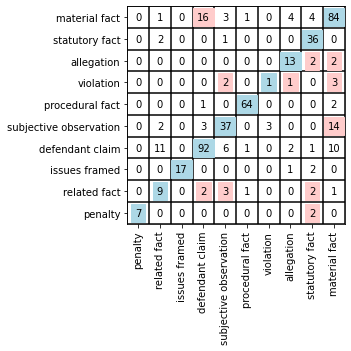

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


height, width = cm.shape
print(height)
print(width)

fig = plt.figure('confusion matrix')
ax = fig.add_subplot(111, aspect='equal')
for x in range(height):
    rowsum = 0
    for y in range(width):
      if x == y:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ADD8E6')
        rowsum += cm[width-x-1][height-y-1]
      else:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center')
        rowsum += cm[width-x-1][height-y-1] 
    #print(f'row {x} sum is {rowsum}')
    for y in range(width):
      if x == y:
        pass
      elif cm[width-x-1][height-y-1] > int(0.1*rowsum):
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ffcccb')
    

offset = .5    
ax.set_xlim(-offset, width - offset)
ax.set_ylim(-offset, height - offset)

ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)



plt.xticks(range(width), classes,rotation=90)
plt.yticks(range(height), classes)
plt.savefig('confusion_matrix.png', format='png')